In [ ]:
!pip install kaggle

# Upload kaggle.json file (API key)
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


!kaggle datasets download -d birdy654/cifake-real-and-ai-generated-synthetic-images
!unzip cifake-real-and-ai-generated-synthetic-images.zip


Streaming output truncated to the last 5000 lines.
  inflating: train/REAL/4500 (10).jpg  
  inflating: train/REAL/4500 (2).jpg  
  inflating: train/REAL/4500 (3).jpg  
  inflating: train/REAL/4500 (4).jpg  
  inflating: train/REAL/4500 (5).jpg  
  inflating: train/REAL/4500 (6).jpg  
  inflating: train/REAL/4500 (7).jpg  
  inflating: train/REAL/4500 (8).jpg  
  inflating: train/REAL/4500 (9).jpg  
  inflating: train/REAL/4500.jpg     
  inflating: train/REAL/4501 (10).jpg  
  inflating: train/REAL/4501 (2).jpg  
  inflating: train/REAL/4501 (3).jpg  
  inflating: train/REAL/4501 (4).jpg  
  inflating: train/REAL/4501 (5).jpg  
  inflating: train/REAL/4501 (6).jpg  
  inflating: train/REAL/4501 (7).jpg  
  inflating: train/REAL/4501 (8).jpg  
  inflating: train/REAL/4501 (9).jpg  
  inflating: train/REAL/4501.jpg     
  inflating: train/REAL/4502 (10).jpg  
  inflating: train/REAL/4502 (2).jpg  
  inflating: train/REAL/4502 (3).jpg  
  inflating: train/REAL/4502 (4).jpg  
  inflating:

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torchvision
import time
import os

In [ ]:
# Load data
train_data_transform = transforms.Compose([
    transforms.Resize(32),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
test_data_transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_data = datasets.ImageFolder('train', transform=train_data_transform)
test_data = datasets.ImageFolder('test', transform=test_data_transform)

# Split train data into 80% train / 20% validation
train_size = int(0.8 * len(train_data))
val_size = len(train_data) - train_size
train_data, val_data = random_split(train_data, [train_size, val_size])

train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
val_loader = DataLoader(val_data, batch_size=128, shuffle=False)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)

for images, labels in train_loader:
  print("Image batch shape:", images.shape)
  print("Label batch shape:", labels.shape)
  break


Image batch shape: torch.Size([128, 3, 32, 32])
Label batch shape: torch.Size([128])


In [ ]:
# Print the number of samples in the train and test sets
print('Number of training samples:', len(train_data))
print('Number of validation samples:', len(val_data))
print('Number of testing samples:', len(test_data))


Number of training samples: 80000
Number of validation samples: 20000
Number of testing samples: 20000


In [ ]:
# Transfer learning model
model = torchvision.models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

for param in model.parameters():
    param.requires_grad = False

for param in model.layer4.parameters():
    param.requires_grad = True
for param in model.fc.parameters():
    param.requires_grad = True

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Hyperparameters
num_epochs = 10
batch_size = 128
learning_rate = 0.005

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)

In [ ]:
# Training loop
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

os.makedirs("model_checkpoints", exist_ok=True)

for epoch in range(num_epochs):
    start_time = time.time()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    model.train()
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    model.eval()
    with torch.no_grad():
      for data in val_loader:
          images, labels = data[0].to(device), data[1].to(device)
          outputs = model(images)
          loss = criterion(outputs, labels)
          val_loss += loss.item()

          _, predicted = torch.max(outputs.data, 1)
          total_val += labels.size(0)
          correct_val += (predicted == labels).sum().item()
    val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    end_time = time.time()
    epoch_time = end_time - start_time

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%, Time: {epoch_time:.2f}s')

timestamp = time.strftime("%Y%m%d_%H%M%S")
checkpoint_filename = f"model_checkpoint_{timestamp}_val_acc_{val_accuracies[-1]:.2f}.pth"
checkpoint_path = os.path.join("model_checkpoints", checkpoint_filename)

torch.save(model.state_dict(), checkpoint_path)
print(f"Model checkpoint saved to: {checkpoint_path}")

Epoch [1/10], Train Loss: 0.2664, Train Acc: 89.37%, Val Loss: 0.1965, Val Acc: 91.64%, Time: 52.57s
Epoch [2/10], Train Loss: 0.1880, Train Acc: 92.52%, Val Loss: 0.1798, Val Acc: 92.67%, Time: 52.44s
Epoch [3/10], Train Loss: 0.1653, Train Acc: 93.44%, Val Loss: 0.1758, Val Acc: 93.04%, Time: 52.35s
Epoch [4/10], Train Loss: 0.1482, Train Acc: 94.10%, Val Loss: 0.1666, Val Acc: 93.30%, Time: 52.81s
Epoch [5/10], Train Loss: 0.1364, Train Acc: 94.56%, Val Loss: 0.1604, Val Acc: 93.73%, Time: 52.65s
Epoch [6/10], Train Loss: 0.1247, Train Acc: 95.06%, Val Loss: 0.1686, Val Acc: 93.23%, Time: 52.30s
Epoch [7/10], Train Loss: 0.1146, Train Acc: 95.51%, Val Loss: 0.1849, Val Acc: 93.44%, Time: 52.37s
Epoch [8/10], Train Loss: 0.1082, Train Acc: 95.81%, Val Loss: 0.3493, Val Acc: 92.44%, Time: 52.41s
Epoch [9/10], Train Loss: 0.1179, Train Acc: 95.53%, Val Loss: 0.1633, Val Acc: 93.78%, Time: 52.62s
Epoch [10/10], Train Loss: 0.0929, Train Acc: 96.42%, Val Loss: 0.1726, Val Acc: 93.64%, Ti

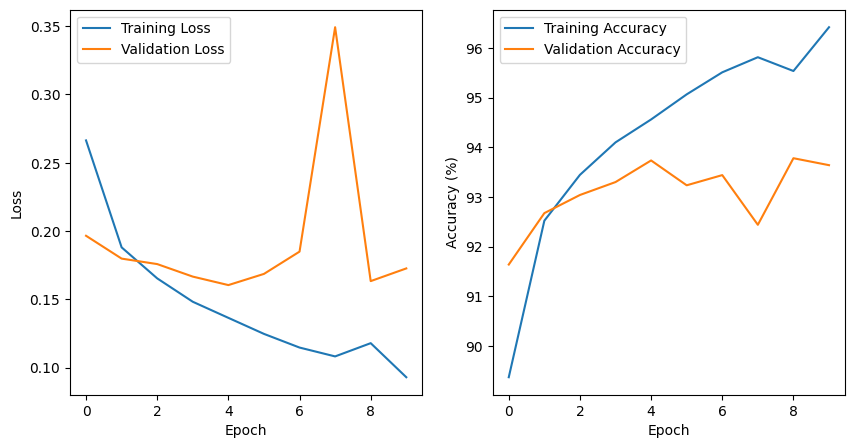

Test Accuracy: 93.78%


In [ ]:
# Plot learning curves
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()


# Evaluation on test data
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f'Test Accuracy: {test_accuracy:.2f}%')
